# Proyecto de series de tiempo univariadas (Red Neuronal Recurrente)
El siguiente Script abarca la modelación de la tasa de desempleo en Colombia; desde enero de 2001 hasta diciembre de 2023; utilizando redes neuronales recurrentes.

## Integrantes: Anderson Guarín, Ander Cristancho, Juan Duitama
## Librerías utilizadas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import tensorflow as tf
import datetime
from datetime import timedelta

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, TimeSeriesSplit, GridSearchCV

import tensorflow.keras as keras

## Importación datos

In [2]:
import os
#Directorio Anderson
os.chdir(r"C:\Users\ander\OneDrive - Universidad Nacional de Colombia\Documentos\(2024-01) Octavo Semestre\Series de Tiempo Univariadas\Proyecto")
#Directorio Duitama
#os.chdir("D:\Estadística\Semestres\Semestre 9\Series de Tiempo Univariadas\Datos")
#Directorio Ander
#os.chdir(r"C:\Users\EQUIPO\OneDrive\Documentos\Documentos Ander\UNAL\Series de tiempo\Mis series y descriptiva")
os.getcwd()

'C:\\Users\\ander\\OneDrive - Universidad Nacional de Colombia\\Documentos\\(2024-01) Octavo Semestre\\Series de Tiempo Univariadas\\Proyecto'

In [3]:
Data = pd.read_excel("Desempleo.xlsx",skiprows=5,nrows=277)
Data = Data.iloc[:,[0,2]]
print(Data.dtypes)
# Cambiar los nombres de las columnas
nuevos_nombres = ['AnioMes', 'TasaDesempleo']
Data.columns = nuevos_nombres
Data

Año-Mes (AAAA-MM)         object
Tasa de desempleo (%)    float64
dtype: object


AnioMes  TasaDesempleo
0    2023-12      10.013717
1    2023-11       9.007386
2    2023-10       9.230912
3    2023-09       9.252674
4    2023-08       9.277372
..       ...            ...
271  2001-05      14.035800
272  2001-04      14.515100
273  2001-03      15.811900
274  2001-02      17.434200
275  2001-01      16.622300

[276 rows x 2 columns]

In [4]:
#Primera observación de los datos
Data['AnioMes']=pd.to_datetime(Data['AnioMes'])#Convirtiendo la columna año y mes a formato fecha
Desempleo=Data.set_index('AnioMes')#Ordenando el dataframe, pero creo uno nuevo para volverlo objeto de series de tiempo luego
Desempleo = Desempleo.iloc[::-1]
Desempleo

TasaDesempleo
AnioMes                  
2001-01-01      16.622300
2001-02-01      17.434200
2001-03-01      15.811900
2001-04-01      14.515100
2001-05-01      14.035800
...                   ...
2023-08-01       9.277372
2023-09-01       9.252674
2023-10-01       9.230912
2023-11-01       9.007386
2023-12-01      10.013717

[276 rows x 1 columns]

El análisis descriptivo fue realizado en scripts previos, de los cuales se seleccionaron los retardos 2, 3, 4, 5, 6, 9, 10, 11 y 12 como features. No obstante, no obtuvimos buenos resultados, por lo tanto utilizaremos todos los retardos.

## Organización de los datos
Utilizaremos el 80% de los datos como entrenamiento y el 20% restante como prueba.

In [5]:
#split = int(len(Data) * 0.8)
#DataTrain = Desempleo.iloc[:split]
#DataTest = Desempleo.iloc[split:]

n_steps = 12 #Utilizaremos los 12 retardos
n_steps_ahead = 1 #Predicción a un paso

### Estandarización

In [6]:
mu = float(Desempleo.mean())
sigma = float(Desempleo.std())

stdize_input = lambda x: (x - mu) / sigma

DataEst = Desempleo.apply(stdize_input)

C:\Users\JUAN DAVID\AppData\Local\Temp\ipykernel_26440\466965433.py:1: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  mu = float(Desempleo.mean())
C:\Users\JUAN DAVID\AppData\Local\Temp\ipykernel_26440\466965433.py:2: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sigma = float(Desempleo.std())


In [7]:
DataEst

TasaDesempleo
AnioMes                  
2001-01-01       1.979110
2001-02-01       2.311865
2001-03-01       1.646969
2001-04-01       1.115478
2001-05-01       0.919038
...                   ...
2023-08-01      -1.031195
2023-09-01      -1.041317
2023-10-01      -1.050236
2023-11-01      -1.141848
2023-12-01      -0.729405

[276 rows x 1 columns]

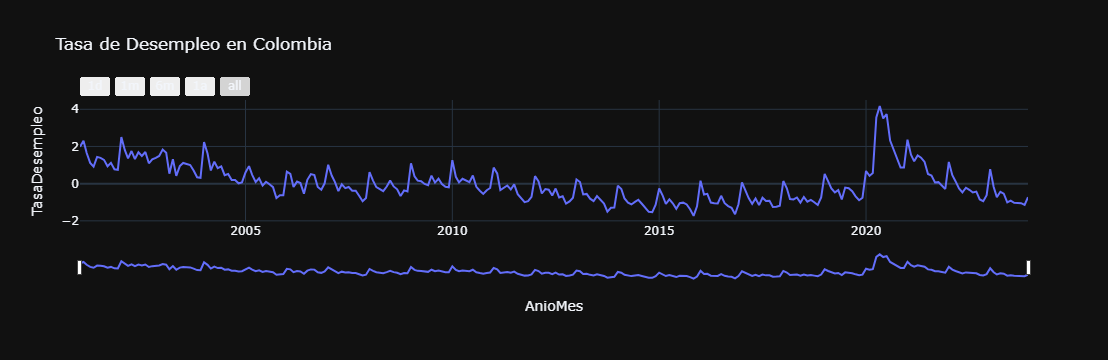

In [8]:
import plotly.express as px
fig = px.line(DataEst, y="TasaDesempleo",title="Tasa de Desempleo en Colombia",template='plotly_dark')#Se le puede quitar el modo oscuro si quiere
fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1d", step="day", stepmode="backward"),
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(count=6, label="6m", step="month", stepmode="backward"),
                dict(count=1, label="1a", step="year", stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    )
)

Creando los tensores con los retardos, trabajaremos con los 12 retardos a pesar de que en la parte descriptiva no los habíamos recomendado

In [9]:
def get_lagged_features(df, n_steps, n_steps_ahead):
    """
    df: pandas DataFrame of time series to be lagged
    n_steps: number of lags, i.e. sequence length
    n_steps_ahead: forecasting horizon
    """
    lag_list = []
    
    for lag in range(n_steps + n_steps_ahead - 1, n_steps_ahead - 1, -1):
        lag_list.append(df.shift(lag))
    lag_array = np.dstack([i[n_steps+n_steps_ahead-1:] for i in lag_list])
    # We swap the last two dimensions so each slice along the first dimension
    # is the same shape as the corresponding segment of the input time series 
    lag_array = np.swapaxes(lag_array, 1, -1)
    return lag_array

In [10]:
Config = get_lagged_features(DataEst, n_steps, n_steps_ahead)
Config.shape

(264, 12, 1)

In [11]:
Partir = int(Config.shape[0]*0.8)

### Entrenamiento

In [12]:
x_train = Config[:Partir]
y_train =  DataEst.values[n_steps + n_steps_ahead - 1:Partir + n_steps + n_steps_ahead - 1]
y_train_timestamps = DataEst.index[n_steps + n_steps_ahead - 1:Partir + n_steps + n_steps_ahead - 1]

Prueba

In [13]:
x_test = Config[Partir:]
y_test =  DataEst.values[Partir + n_steps + n_steps_ahead - 1:]
y_test_timestamps = DataEst.index[Partir + n_steps + n_steps_ahead - 1:]

In [14]:
print([tensor.shape for tensor in (x_train, y_train, x_test, y_test)])

[(211, 12, 1), (211, 1), (53, 12, 1), (53, 1)]


## Creación de las redes neuronales
Tres redes neuronales recurrentes serán implementadas, una simple, una GRU (Gated Recurrent Unit) y una LSTM (Long Short-Term Memory).

In [15]:
def SimpleRNN_(n_units, l1_reg, seed=1729):
  #def SimpleRNN_(n_units = 10, seed=0):
  model = keras.models.Sequential()
  model.add(keras.layers.SimpleRNN(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=keras.regularizers.L1(l1_reg), input_shape=(x_train.shape[1], x_train.shape[-1]), unroll=True, stateful=False))  
  model.add(keras.layers.Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=keras.regularizers.L1(l1_reg)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model

def GRU_(n_units, l1_reg, seed=1729):
  #def GRU_(n_units = 10, seed=0):
  model = keras.models.Sequential()
  model.add(keras.layers.GRU(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=keras.regularizers.L1(l1_reg), input_shape=(x_train.shape[1], x_train.shape[-1]), unroll=True))  
  model.add(keras.layers.Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=keras.regularizers.L1(l1_reg)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model

def LSTM_(n_units, l1_reg, seed=1729):
  #def LSTM_(n_units = 10,  seed=0):
  model = keras.models.Sequential()
  model.add(keras.layers.LSTM(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=keras.regularizers.L1(l1_reg), input_shape=(x_train.shape[1], x_train.shape[-1]), unroll=True)) 
  model.add(keras.layers.Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=keras.regularizers.L1(l1_reg)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model

Definimos las épocas y mantenemos un batch de 12

In [16]:
max_epochs = 100 #Definimos 100 épocas
batch_size = 12# Mantenemos el tamaño del batch

In [17]:
es = keras.callbacks.EarlyStopping(monitor='loss', mode='min', verbose=1, patience=10, min_delta=1e-7, restore_best_weights=True)
params = {
    'rnn': {
        'model': None, 'function': SimpleRNN_, 'l1_reg': 0.0, 'H': 20, 
        'color': 'blue', 'label':'RNN'}, 
    'gru': {
        'model': None, 'function':GRU_,'l1_reg': 0.0, 'H': 10, 
        'color': 'orange', 'label': 'GRU'},
    'lstm': {
        'model': None, 'function': LSTM_,'l1_reg': 0.0, 'H': 10, 
        'color':'red', 'label': 'LSTM'}
}

In [18]:
do_training = False
#do_training = True

## Validación Cruzada

In [19]:
from scikeras.wrappers import KerasRegressor

In [20]:
cross_val = True # WARNING: Changing this to True will take many hours to run

if do_training and cross_val:
    n_units = [5, 10, 20]
    l1_reg = [0, 0.001, 0.01, 0.1]
    
    # A dictionary containing a list of values to be iterated through
    # for each parameter of the model included in the search
    param_grid = {'n_units': n_units, 'l1_reg': l1_reg}
    
    # In the kth split, TimeSeriesSplit returns first k folds 
    # as training set and the (k+1)th fold as test set.
    tscv = TimeSeriesSplit(n_splits = 5)
    
    # A grid search is performed for each of the models, and the parameter set which
    # performs best over all the cross-validation splits is saved in the `params` dictionary
    for key in params.keys():
        print('Performing cross-validation. Model:', key)
        model = KerasRegressor(model=params[key]['function'], epochs=max_epochs, 
                               batch_size=batch_size, verbose=2, l1_reg=0, n_units=10)
        #from scikeras.wrappers import KerasClassifier, KerasRegressor
        grid = GridSearchCV(estimator=model, param_grid=param_grid, 
                            cv=tscv, n_jobs=1, verbose=2)
        grid_result = grid.fit(x_train, y_train, callbacks=[es])
        print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
        
        means = grid_result.cv_results_['mean_test_score']
        stds = grid_result.cv_results_['std_test_score']
        params_ = grid_result.cv_results_['params']
        for mean, stdev, param_ in zip(means, stds, params_):
            print("%f (%f) with %r" % (mean, stdev, param_))
            
        params[key]['H'] = grid_result.best_params_['n_units']
        params[key]['l1_reg']= grid_result.best_params_['l1_reg']

## Entrenamiento del modelo

In [21]:
if do_training is True:
    for key in params.keys():
        tf.random.set_seed(1729)
        print('Training', key, 'model')
        model = params[key]['function'](params[key]['H'], params[key]['l1_reg'])
        model.fit(x_train, y_train, epochs=max_epochs, 
                  batch_size=batch_size, callbacks=[es], shuffle=False)
        params[key]['model'] = model

## Guardando el modelo entrenado

In [22]:
if do_training is True:
    for key in params.keys():
        params[key]['model'].save('RNNs-Desempleo-SAVED-' + key + '.hdf5', overwrite=True)  # creates a HDF5 file
        params[key]['model'].save('RNNs-Desempleo-SAVED-' + key + '.keras', overwrite=True)  # creates a HDF5 file

## Importando el modelo entrenado
Cuando vuelva a este script no hago el entrenamiento de nuevo sino simplemento cargo el modelo guardado

In [23]:
do_training = False
if do_training is False:
     for key in params.keys():
        params[key]['model']=keras.models.load_model('RNNs-Desempleo-SAVED-' + key + '.hdf5')

## Desempeño de los modelos

In [24]:
for key in params.keys():
    model = params[key]['model']
    model.summary()
    
    params[key]['pred_train'] = model.predict(x_train, verbose=1)#Predicciones del conjunto de entrenamiento
    params[key]['MSE_train'] = mean_squared_error(y_train, params[key]['pred_train'])#MSE en entrenamiento
    
    params[key]['pred_test'] = model.predict(x_test, verbose=1)#Predicciones del conjunto de prueba
    params[key]['MSE_test'] = mean_squared_error(y_test, params[key]['pred_test'])#MSE en prueba

Model: "sequential_183"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_61 (SimpleRNN)       │ (None, 20)             │           440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_183 (Dense)               │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 463 (1.81 KB)

 Trainable params: 461 (1.80 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


Model: "sequential_184"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_61 (GRU)                    │ (None, 10)             │           390 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_184 (Dense)               │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 403 (1.58 KB)

 Trainable params: 401 (1.57 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Model: "sequential_185"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_61 (LSTM)                  │ (None, 5)              │           140 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_185 (Dense)               │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148 (596.00 B)

 Trainable params: 146 (584.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


## Revisión de los MSE en los conjuntos de prueba

In [25]:
for key in params.keys():
    print('El MSE de la red',key, 'en el conjunto de prueba es',params[key]['MSE_test'])

El MSE de la red rnn en el conjunto de prueba es 4.147546744922402
El MSE de la red gru en el conjunto de prueba es 2.088970242348047
El MSE de la red lstm en el conjunto de prueba es 3.4274432277062936


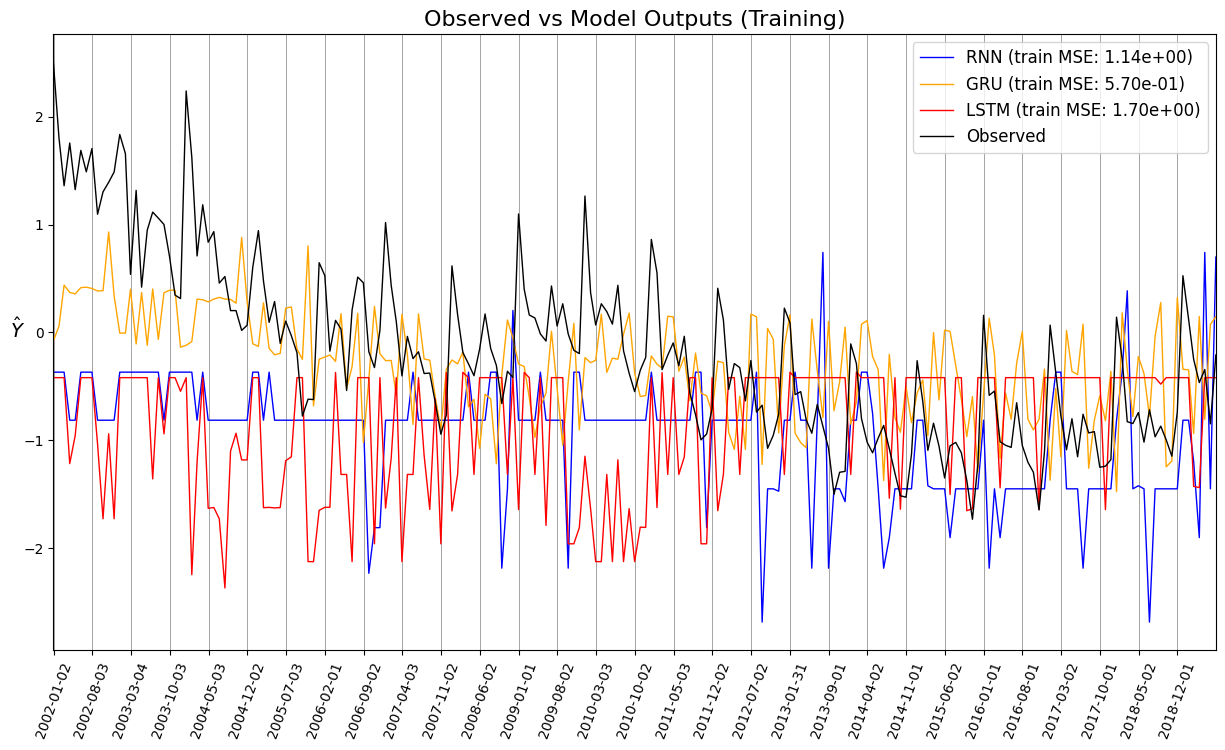

In [26]:
max_pts = 10**4
compare = params.keys() # e.g. ['rnn', 'alpharnn'] or ['lstm']
l, u = (None, None) # lower and upper indices of range to plot 
ds = max(1, len(y_train[l:u])//max_pts) # Downsampling ratio for under `max_pts`
                                        # per series.  Set `None` to disable. 

fig = plt.figure(figsize=(15,8))
x_vals = y_train_timestamps[l:u:ds]
for key in compare:
    y_vals = params[key]['pred_train'][l:u:ds]
    label = params[key]['label'] + ' (train MSE: %.2e)' % params[key]['MSE_train']
    plt.plot(x_vals, y_vals, c=params[key]['color'], label=label, lw=1)
plt.plot(x_vals, y_train[l:u:ds], c="black", label="Observed", lw=1)
start, end = x_vals.min(), x_vals.max()
xticks =  [start.date() + timedelta(days=(1+i)) for i in range(1 + (end - start).days)]
xticks = xticks[::max(1, len(xticks)//30)]
for t in xticks: plt.axvline(x=t, c='gray', linewidth=0.5, zorder=0)
plt.xticks(xticks, rotation=70)
plt.xlim(start, end)
plt.ylabel('$\hat{Y}$', rotation=0, fontsize=14)
plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model Outputs (Training)', fontsize=16);

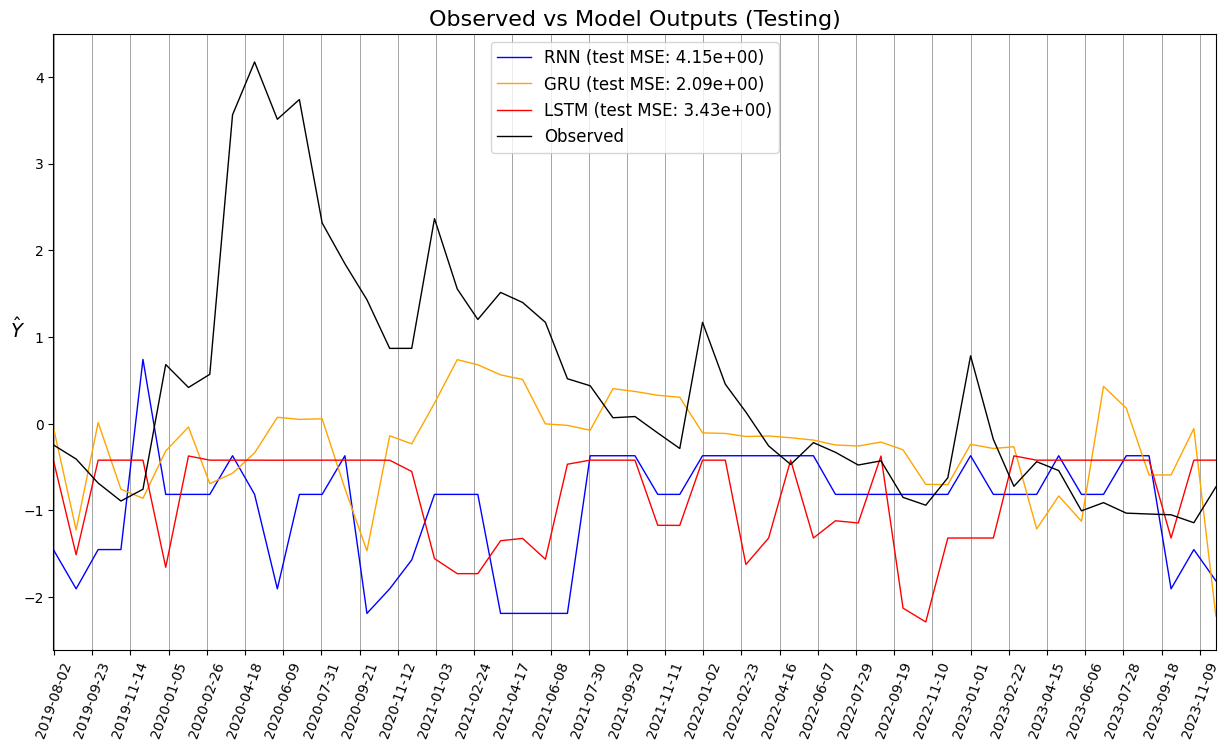

In [27]:
compare = params.keys() # e.g. ['rnn', 'alpharnn'] or ['lstm']
l, u = (None, None) # lower and upper indices of range to plot 
ds = max(1, len(y_train[l:u])//max_pts) # Downsampling ratio for under `max_pts`
                                        # per series.  Set `None` to disable.
fig = plt.figure(figsize=(15,8))
x_vals = y_test_timestamps[l:u:ds]
for key in compare:
    y_vals = params[key]['pred_test'][l:u:ds]
    label = params[key]['label'] + ' (test MSE: %.2e)' % params[key]['MSE_test']
    plt.plot(x_vals, y_vals, c=params[key]['color'], label=label, lw=1)
plt.plot(x_vals, y_test[l:u:ds], c="black", label="Observed", lw=1)
start, end = x_vals.min(), x_vals.max()
xticks =  [start.date() + timedelta(days=(1+i)) for i in range(1 + (end - start).days)]
xticks = xticks[::max(1, len(xticks)//30)]
for t in xticks: plt.axvline(x=t, c='gray', linewidth=0.5, zorder=0)
plt.xticks(xticks, rotation=70)
plt.xlim(start, end)
plt.ylabel('$\hat{Y}$', rotation=0, fontsize=14)
plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model Outputs (Testing)', fontsize=16);

# Agregando estacionalidad para intentar mejorar pronósticos (Dummies)
Agregaremos una nueva covariable, el mes que se va a predecir

In [28]:
#Creamos las dummies de los meses
meses = ["Febrero", "Marzo", "Abril", "Mayo", "Junio", "Julio", "Agosto", "Septiembre", "Octubre", "Noviembre", "Diciembre", "Enero"]
meses_repetidos = (meses * (len(DataEst) // len(meses) + 1))[:len(DataEst)]
meses = pd.DataFrame({'MesSiguiente': meses_repetidos})
meses_dummies = pd.get_dummies(meses, columns=['MesSiguiente'])
meses_dummies

MesSiguiente_Abril  MesSiguiente_Agosto  MesSiguiente_Diciembre  \
0                 False                False                   False   
1                 False                False                   False   
2                  True                False                   False   
3                 False                False                   False   
4                 False                False                   False   
..                  ...                  ...                     ...   
271               False                False                   False   
272               False                False                   False   
273               False                False                   False   
274               False                False                    True   
275               False                False                   False   

     MesSiguiente_Enero  MesSiguiente_Febrero  MesSiguiente_Julio  \
0                 False                  True               False   
1                 False                 False               False   
2                 False                 False               False   
3                 False                 False               False   
4                 False                 False               False   
..                  ...                   ...                 ...   
271               False                 False               False   
272               False                 False               False   
273               False                 False               False   
274               False                 False               False   
275                True                 False               False   

     MesSiguiente_Junio  MesSiguiente_Marzo  MesSiguiente_Mayo  \
0                 False               False              False   
1                 False                True              False   
2                 False               False              False   
3                 False               False               True   
4                  True               False              False   
..                  ...                 ...                ...   
271               False               False              False   
272               False               False              False   
273               False               False              False   
274               False               False              False   
275               False               False              False   

     MesSiguiente_Noviembre  MesSiguiente_Octubre  MesSiguiente_Septiembre  
0                     False                 False                    False  
1                     False                 False                    False  
2                     False                 False                    False  
3                     False                 False                    False  
4                     False                 False                    False  
..                      ...                   ...                      ...  
271                   False                 False                     True  
272                   False                  True                    False  
273                    True                 False                    False  
274                   False                 False                    False  
275                   False                 False                    False  

[276 rows x 12 columns]

Obteniendo las observaciones que estarán en el conjunto de entrenamiento y prueba

In [29]:
anadir1 = meses_dummies.iloc[12:Partir+12,:11]
anadir2 = meses_dummies.iloc[Partir+12:,:11]

In [30]:
x_trainNew = np.concatenate((x_train, anadir1.values.reshape(Partir,11,1)), axis=1)
x_testNew = np.concatenate((x_test, anadir2.values.reshape(len(y_test),11,1)), axis=1)

In [31]:
x_trainNew.shape

(211, 23, 1)

In [32]:
params2 = {
    'rnn': {
        'model': None, 'function': SimpleRNN_, 'l1_reg': 0.0, 'H': 20, 
        'color': 'blue', 'label':'RNN'}, 
    'gru': {
        'model': None, 'function':GRU_,'l1_reg': 0.0, 'H': 10, 
        'color': 'orange', 'label': 'GRU'},
    'lstm': {
        'model': None, 'function': LSTM_,'l1_reg': 0.0, 'H': 10, 
        'color':'red', 'label': 'LSTM'}
}

Validación cruzada

In [33]:
#do_training = True
do_training = False
cross_val = True # WARNING: Changing this to True will take many hours to run

if do_training and cross_val:
    n_units = [5, 10, 20]
    l1_reg = [0, 0.001, 0.01, 0.1]
    
    # A dictionary containing a list of values to be iterated through
    # for each parameter of the model included in the search
    param_grid = {'n_units': n_units, 'l1_reg': l1_reg}
    
    # In the kth split, TimeSeriesSplit returns first k folds 
    # as training set and the (k+1)th fold as test set.
    tscv = TimeSeriesSplit(n_splits = 5)
    
    # A grid search is performed for each of the models, and the parameter set which
    # performs best over all the cross-validation splits is saved in the `params` dictionary
    for key in params2.keys():
        print('Performing cross-validation. Model:', key)
        model = KerasRegressor(model=params2[key]['function'], epochs=max_epochs, 
                               batch_size=batch_size, verbose=2, l1_reg=0, n_units=10)
        #from scikeras.wrappers import KerasClassifier, KerasRegressor
        grid = GridSearchCV(estimator=model, param_grid=param_grid, 
                            cv=tscv, n_jobs=1, verbose=2)
        grid_result = grid.fit(x_trainNew, y_train, callbacks=[es])
        print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
        
        means = grid_result.cv_results_['mean_test_score']
        stds = grid_result.cv_results_['std_test_score']
        params_ = grid_result.cv_results_['params']
        for mean, stdev, param_ in zip(means, stds, params_):
            print("%f (%f) with %r" % (mean, stdev, param_))
            
        params2[key]['H'] = grid_result.best_params_['n_units']
        params2[key]['l1_reg']= grid_result.best_params_['l1_reg']

Entrenamiento del modelo

In [34]:
if do_training is True:
    for key in params2.keys():
        tf.random.set_seed(1729)
        print('Training', key, 'model')
        model = params2[key]['function'](params2[key]['H'], params2[key]['l1_reg'])
        model.fit(x_trainNew, y_train, epochs=max_epochs, 
                  batch_size=batch_size, callbacks=[es], shuffle=False)
        params2[key]['model'] = model

Guardando el modelo entrenado

In [35]:
if do_training is True:
    for key in params2.keys():
        params2[key]['model'].save('RNNs-Desempleo-SAVED2-' + key + '.hdf5', overwrite=True)  # creates a HDF5 file
        params2[key]['model'].save('RNNs-Desempleo-SAVED2-' + key + '.keras', overwrite=True)  # creates a HDF5 file

Importando el modelo entrenado

In [36]:
do_training = False
if do_training is False:
     for key in params2.keys():
        params2[key]['model']=keras.models.load_model('RNNs-Desempleo-SAVED2-' + key + '.hdf5')

Desempeño de los modelos

In [37]:
for key in params2.keys():
    model = params2[key]['model']
    model.summary()
    
    params2[key]['pred_train'] = model.predict(x_trainNew, verbose=1)#Predicciones del conjunto de entrenamiento
    params2[key]['MSE_train'] = mean_squared_error(y_train, params2[key]['pred_train'])#MSE en entrenamiento
    
    params2[key]['pred_test'] = model.predict(x_testNew, verbose=1)#Predicciones del conjunto de prueba
    params2[key]['MSE_test'] = mean_squared_error(y_test, params2[key]['pred_test'])#MSE en prueba

Model: "sequential_295"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_122 (SimpleRNN)      │ (None, 10)             │           120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_295 (Dense)               │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 133 (536.00 B)

 Trainable params: 131 (524.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


Model: "sequential_296"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_112 (GRU)                   │ (None, 5)              │           120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_296 (Dense)               │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 128 (516.00 B)

 Trainable params: 126 (504.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 291ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


Model: "sequential_297"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_61 (LSTM)                  │ (None, 10)             │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_297 (Dense)               │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 493 (1.93 KB)

 Trainable params: 491 (1.92 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 172ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


Revision del MSE en los conjuntos de prueba

In [38]:
for key in params2.keys():
    print('El MSE de la red',key, 'en el conjunto de prueba es',params2[key]['MSE_test'])

El MSE de la red rnn en el conjunto de prueba es 3.061085243617479
El MSE de la red gru en el conjunto de prueba es 2.5457583596013396
El MSE de la red lstm en el conjunto de prueba es 5.192383681209684


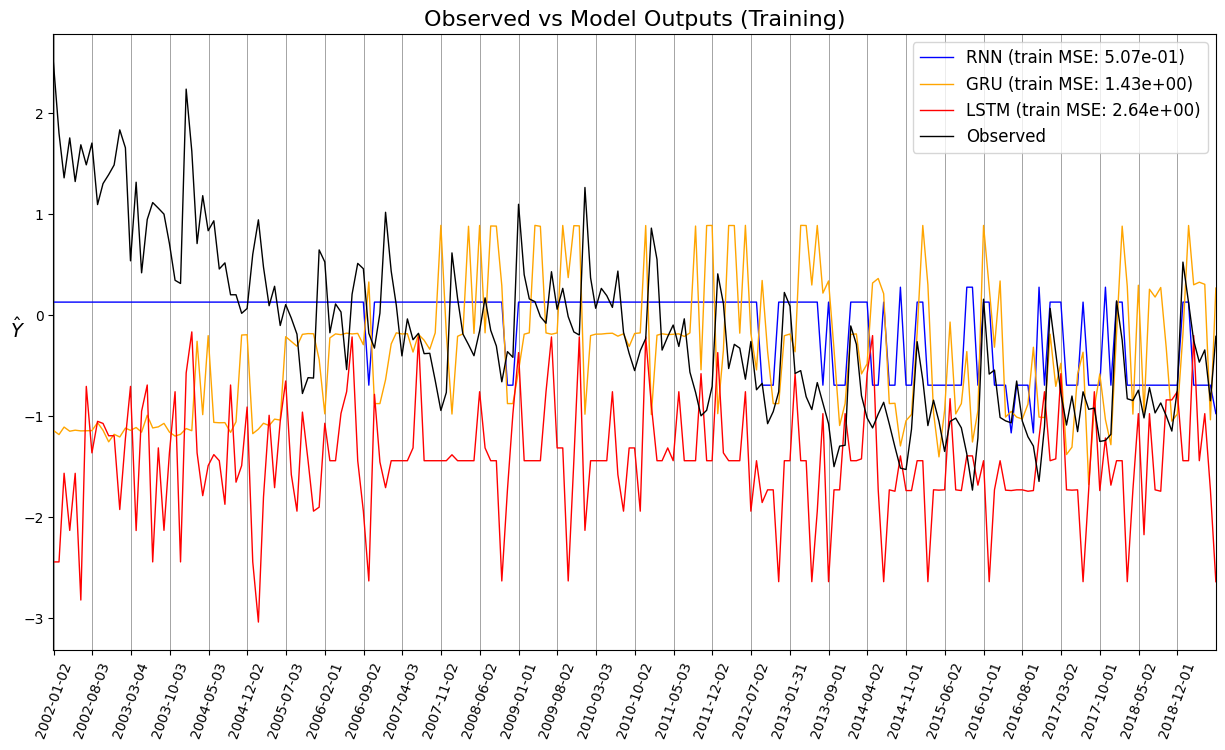

In [39]:
max_pts = 10**4
compare = params.keys() # e.g. ['rnn', 'alpharnn'] or ['lstm']
l, u = (None, None) # lower and upper indices of range to plot 
ds = max(1, len(y_train[l:u])//max_pts) # Downsampling ratio for under `max_pts`
                                        # per series.  Set `None` to disable. 

fig = plt.figure(figsize=(15,8))
x_vals = y_train_timestamps[l:u:ds]
for key in compare:
    y_vals = params2[key]['pred_train'][l:u:ds]
    label = params2[key]['label'] + ' (train MSE: %.2e)' % params2[key]['MSE_train']
    plt.plot(x_vals, y_vals, c=params2[key]['color'], label=label, lw=1)
plt.plot(x_vals, y_train[l:u:ds], c="black", label="Observed", lw=1)
start, end = x_vals.min(), x_vals.max()
xticks =  [start.date() + timedelta(days=(1+i)) for i in range(1 + (end - start).days)]
xticks = xticks[::max(1, len(xticks)//30)]
for t in xticks: plt.axvline(x=t, c='gray', linewidth=0.5, zorder=0)
plt.xticks(xticks, rotation=70)
plt.xlim(start, end)
plt.ylabel('$\hat{Y}$', rotation=0, fontsize=14)
plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model Outputs (Training)', fontsize=16);

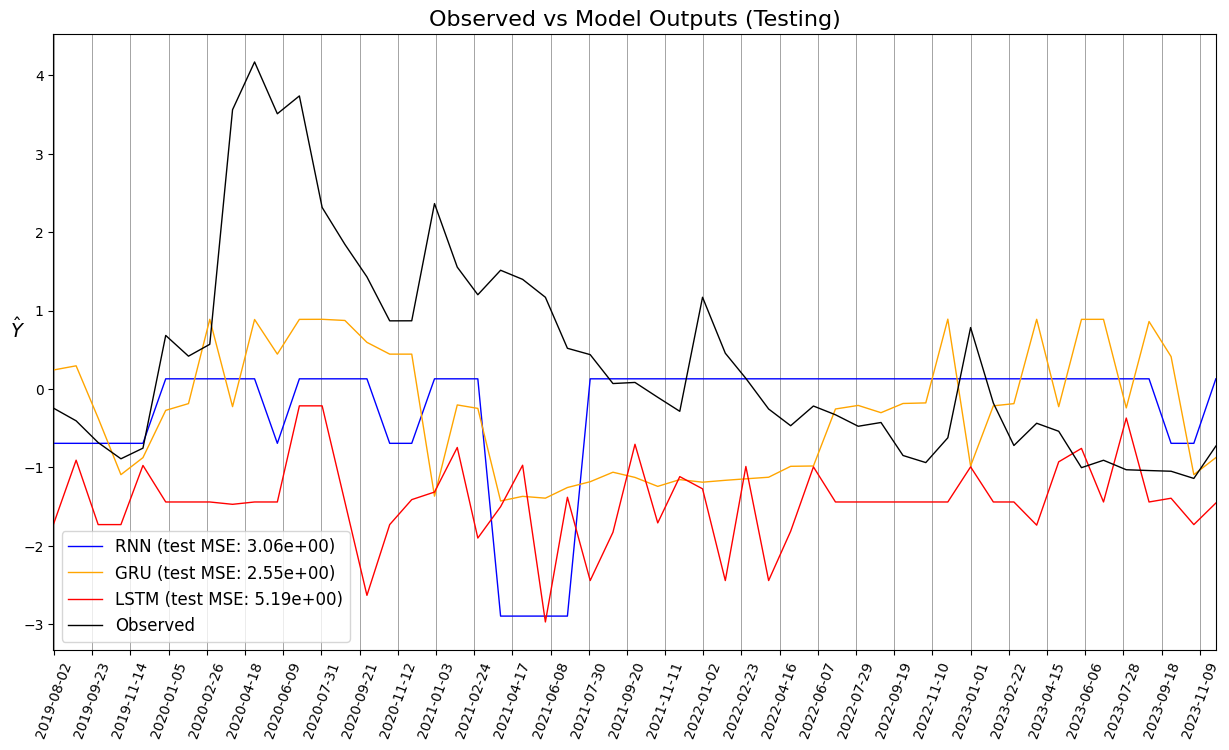

In [40]:
compare = params.keys() # e.g. ['rnn', 'alpharnn'] or ['lstm']
l, u = (None, None) # lower and upper indices of range to plot 
ds = max(1, len(y_train[l:u])//max_pts) # Downsampling ratio for under `max_pts`
                                        # per series.  Set `None` to disable.
fig = plt.figure(figsize=(15,8))
x_vals = y_test_timestamps[l:u:ds]
for key in compare:
    y_vals = params2[key]['pred_test'][l:u:ds]
    label = params2[key]['label'] + ' (test MSE: %.2e)' % params2[key]['MSE_test']
    plt.plot(x_vals, y_vals, c=params2[key]['color'], label=label, lw=1)
plt.plot(x_vals, y_test[l:u:ds], c="black", label="Observed", lw=1)
start, end = x_vals.min(), x_vals.max()
xticks =  [start.date() + timedelta(days=(1+i)) for i in range(1 + (end - start).days)]
xticks = xticks[::max(1, len(xticks)//30)]
for t in xticks: plt.axvline(x=t, c='gray', linewidth=0.5, zorder=0)
plt.xticks(xticks, rotation=70)
plt.xlim(start, end)
plt.ylabel('$\hat{Y}$', rotation=0, fontsize=14)
plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model Outputs (Testing)', fontsize=16);

# Agregando estacionalidad para intentar mejorar pronósticos (Componentes de Fourier)
Agregar la estacionalidad con variables dummy no mejoró los pronósticos, tanto en entrenamiento como en prueba, estas fueron decepcionantes; añadiremos componentes de Fourier para intentar mejorar el modelamiento añadiendo estacionalidad.

In [41]:
day = 24*60*60
year = (365.2425)*day

AnioyMes = Data['AnioMes']
AnioyMes = AnioyMes.map(pd.Timestamp.timestamp) ###Convierte las fechas a float
Data['AnioSin'] = np.sin(AnioyMes * (2 * np.pi / year))
Data['AnioCos'] = np.cos(AnioyMes * (2 * np.pi / year))
Data

AnioMes  TasaDesempleo   AnioSin   AnioCos
0   2023-12-01      10.013717 -0.509773  0.860309
1   2023-11-01       9.007386 -0.867922  0.496700
2   2023-10-01       9.230912 -0.999909 -0.013493
3   2023-09-01       9.252674 -0.863021 -0.505168
4   2023-08-01       9.277372 -0.486373 -0.873751
..         ...            ...       ...       ...
271 2001-05-01      14.035800  0.876700 -0.481037
272 2001-04-01      14.515100  0.999899  0.014246
273 2001-03-01      15.811900  0.853812  0.520582
274 2001-02-01      17.434200  0.515496  0.856892
275 2001-01-01      16.622300  0.008300  0.999966

[276 rows x 4 columns]

No se ve prometedor.

Añadiendo las nuevas variables

In [42]:
anadir11 = Data.iloc[12:Partir+12,[2,3]]
anadir21 = Data.iloc[Partir+12:,[2,3]]

In [43]:
x_trainNew1 = np.concatenate((x_train, anadir11.values.reshape(Partir,2,1)), axis=1)
x_testNew1 = np.concatenate((x_test, anadir21.values.reshape(len(y_test),2,1)), axis=1)

In [44]:
params3 = {
    'rnn': {
        'model': None, 'function': SimpleRNN_, 'l1_reg': 0.0, 'H': 20, 
        'color': 'blue', 'label':'RNN'}, 
    'gru': {
        'model': None, 'function':GRU_,'l1_reg': 0.0, 'H': 10, 
        'color': 'orange', 'label': 'GRU'},
    'lstm': {
        'model': None, 'function': LSTM_,'l1_reg': 0.0, 'H': 10, 
        'color':'red', 'label': 'LSTM'}
}

In [45]:
#do_training = True
do_training = False
cross_val = True # WARNING: Changing this to True will take many hours to run

if do_training and cross_val:
    n_units = [5, 10, 20]
    l1_reg = [0, 0.001, 0.01, 0.1]
    
    # A dictionary containing a list of values to be iterated through
    # for each parameter of the model included in the search
    param_grid = {'n_units': n_units, 'l1_reg': l1_reg}
    
    # In the kth split, TimeSeriesSplit returns first k folds 
    # as training set and the (k+1)th fold as test set.
    tscv = TimeSeriesSplit(n_splits = 5)
    
    # A grid search is performed for each of the models, and the parameter set which
    # performs best over all the cross-validation splits is saved in the `params` dictionary
    for key in params3.keys():
        print('Performing cross-validation. Model:', key)
        model = KerasRegressor(model=params3[key]['function'], epochs=max_epochs, 
                               batch_size=batch_size, verbose=2, l1_reg=0, n_units=10)
        #from scikeras.wrappers import KerasClassifier, KerasRegressor
        grid = GridSearchCV(estimator=model, param_grid=param_grid, 
                            cv=tscv, n_jobs=1, verbose=2)
        grid_result = grid.fit(x_trainNew1, y_train, callbacks=[es])
        print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
        
        means = grid_result.cv_results_['mean_test_score']
        stds = grid_result.cv_results_['std_test_score']
        params_ = grid_result.cv_results_['params']
        for mean, stdev, param_ in zip(means, stds, params_):
            print("%f (%f) with %r" % (mean, stdev, param_))
            
        params3[key]['H'] = grid_result.best_params_['n_units']
        params3[key]['l1_reg']= grid_result.best_params_['l1_reg']

Entrenamiento del modelo

In [46]:
if do_training is True:
    for key in params3.keys():
        tf.random.set_seed(1729)
        print('Training', key, 'model')
        model = params3[key]['function'](params3[key]['H'], params3[key]['l1_reg'])
        model.fit(x_trainNew1, y_train, epochs=max_epochs, 
                  batch_size=batch_size, callbacks=[es], shuffle=False)
        params3[key]['model'] = model

Guardando el modelo entrenado

In [47]:
if do_training is True:
    for key in params3.keys():
        params3[key]['model'].save('RNNs-Desempleo-SAVED3-' + key + '.hdf5', overwrite=True)  # creates a HDF5 file
        params3[key]['model'].save('RNNs-Desempleo-SAVED3-' + key + '.keras', overwrite=True)  # creates a HDF5 file

Importando el modelo entrenado

In [48]:
do_training = False
if do_training is False:
     for key in params3.keys():
        params3[key]['model']=keras.models.load_model('RNNs-Desempleo-SAVED3-' + key + '.hdf5')

Desempeño de los modelos

In [49]:
for key in params3.keys():
    model = params3[key]['model']
    model.summary()
    
    params3[key]['pred_train'] = model.predict(x_trainNew1, verbose=1)#Predicciones del conjunto de entrenamiento
    params3[key]['MSE_train'] = mean_squared_error(y_train, params3[key]['pred_train'])#MSE en entrenamiento
    
    params3[key]['pred_test'] = model.predict(x_testNew1, verbose=1)#Predicciones del conjunto de prueba
    params3[key]['MSE_test'] = mean_squared_error(y_test, params3[key]['pred_test'])#MSE en prueba

Model: "sequential_555"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_185 (SimpleRNN)      │ (None, 20)             │           440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_555 (Dense)               │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 463 (1.81 KB)

 Trainable params: 461 (1.80 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


Model: "sequential_556"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_185 (GRU)                   │ (None, 5)              │           120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_556 (Dense)               │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 128 (516.00 B)

 Trainable params: 126 (504.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 261ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Model: "sequential_557"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_185 (LSTM)                 │ (None, 5)              │           140 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_557 (Dense)               │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148 (596.00 B)

 Trainable params: 146 (584.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  


Revisión del MSE en los conjuntos de prueba

In [50]:
for key in params3.keys():
    print('El MSE de la red',key, 'en el conjunto de prueba es',params3[key]['MSE_test'])

El MSE de la red rnn en el conjunto de prueba es 7.778538291544479
El MSE de la red gru en el conjunto de prueba es 7.893496226579509
El MSE de la red lstm en el conjunto de prueba es 4.436413749542612


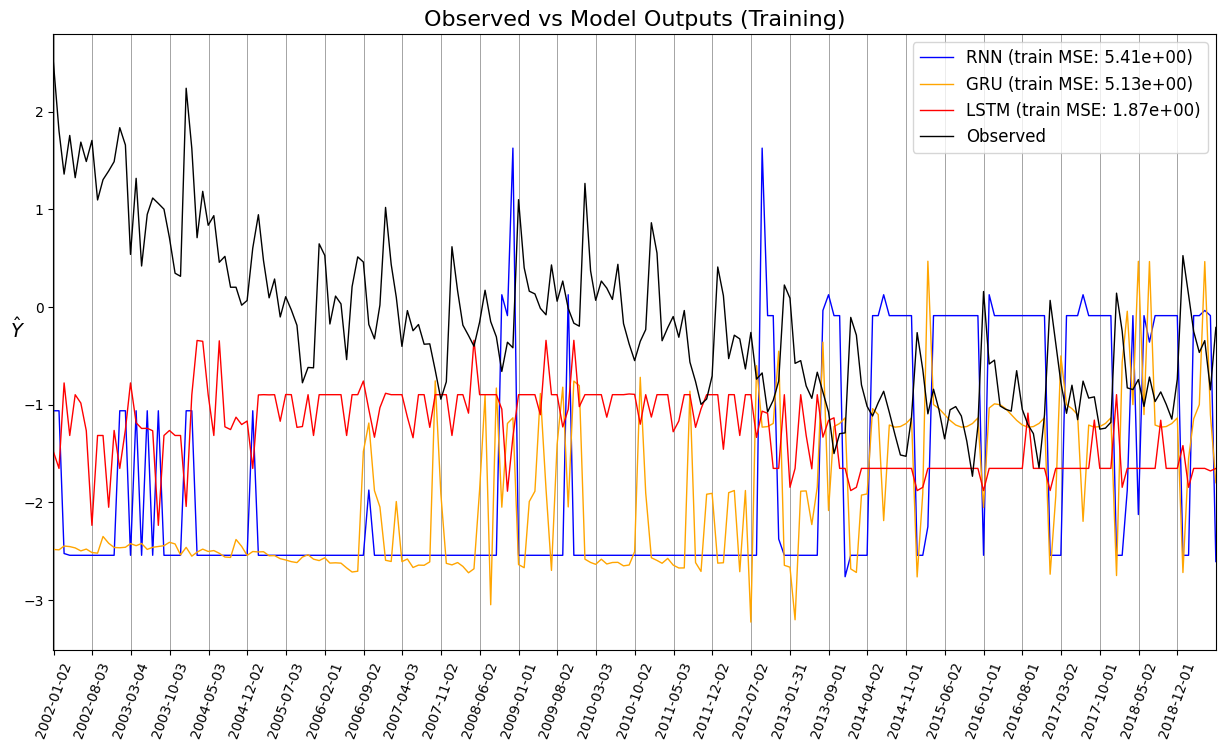

In [51]:
max_pts = 10**4
compare = params.keys() # e.g. ['rnn', 'alpharnn'] or ['lstm']
l, u = (None, None) # lower and upper indices of range to plot 
ds = max(1, len(y_train[l:u])//max_pts) # Downsampling ratio for under `max_pts`
                                        # per series.  Set `None` to disable. 

fig = plt.figure(figsize=(15,8))
x_vals = y_train_timestamps[l:u:ds]
for key in compare:
    y_vals = params3[key]['pred_train'][l:u:ds]
    label = params3[key]['label'] + ' (train MSE: %.2e)' % params3[key]['MSE_train']
    plt.plot(x_vals, y_vals, c=params2[key]['color'], label=label, lw=1)
plt.plot(x_vals, y_train[l:u:ds], c="black", label="Observed", lw=1)
start, end = x_vals.min(), x_vals.max()
xticks =  [start.date() + timedelta(days=(1+i)) for i in range(1 + (end - start).days)]
xticks = xticks[::max(1, len(xticks)//30)]
for t in xticks: plt.axvline(x=t, c='gray', linewidth=0.5, zorder=0)
plt.xticks(xticks, rotation=70)
plt.xlim(start, end)
plt.ylabel('$\hat{Y}$', rotation=0, fontsize=14)
plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model Outputs (Training)', fontsize=16);

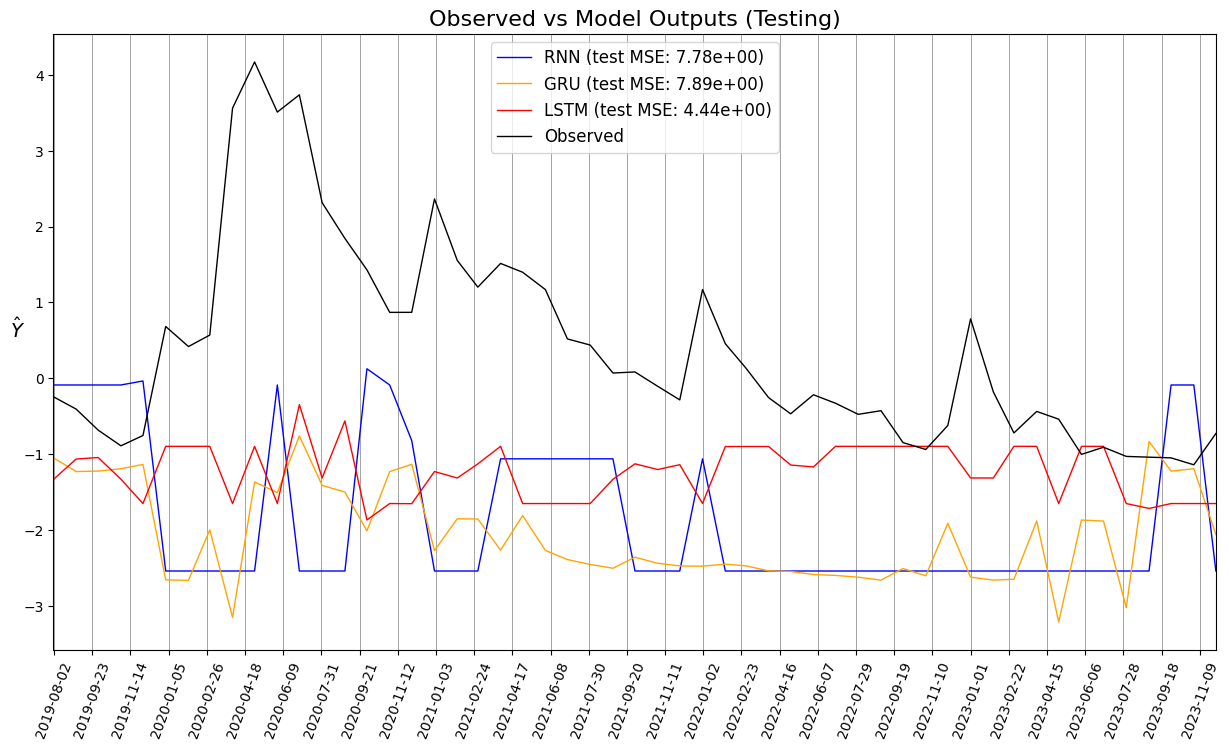

In [52]:
compare = params.keys() # e.g. ['rnn', 'alpharnn'] or ['lstm']
l, u = (None, None) # lower and upper indices of range to plot 
ds = max(1, len(y_train[l:u])//max_pts) # Downsampling ratio for under `max_pts`
                                        # per series.  Set `None` to disable.
fig = plt.figure(figsize=(15,8))
x_vals = y_test_timestamps[l:u:ds]
for key in compare:
    y_vals = params3[key]['pred_test'][l:u:ds]
    label = params3[key]['label'] + ' (test MSE: %.2e)' % params3[key]['MSE_test']
    plt.plot(x_vals, y_vals, c=params2[key]['color'], label=label, lw=1)
plt.plot(x_vals, y_test[l:u:ds], c="black", label="Observed", lw=1)
start, end = x_vals.min(), x_vals.max()
xticks =  [start.date() + timedelta(days=(1+i)) for i in range(1 + (end - start).days)]
xticks = xticks[::max(1, len(xticks)//30)]
for t in xticks: plt.axvline(x=t, c='gray', linewidth=0.5, zorder=0)
plt.xticks(xticks, rotation=70)
plt.xlim(start, end)
plt.ylabel('$\hat{Y}$', rotation=0, fontsize=14)
plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model Outputs (Testing)', fontsize=16);

Haber añadido las covariables de estacionalidad no parecen en principio mejorar las predicciones, ya que sus MSE son mayores

# Añadiendo tendencia
Las predicciones de la red neuronal aparentan no capturar la tendencia de la serie, por lo tanto, añadiremos una nueva covariable, la cual consiste en el promedio de las anteriores 6 observaciones.

Creando el vector con la nueva covariable

In [53]:
Tendencia = np.zeros(len(DataEst))
for i in range(6, len(DataEst)):
    Tendencia[i] = np.mean(DataEst[i-6:i])

In [54]:
anadir21 = Tendencia[12:Partir+12]
anadir22 = Tendencia[Partir+12:]

In [55]:
x_trainNew3 = np.concatenate((x_train, anadir21.reshape(Partir,1,1)), axis=1)
x_testNew3 = np.concatenate((x_test, anadir22.reshape(len(y_test),1,1)), axis=1)

In [56]:
params4 = {
    'rnn': {
        'model': None, 'function': SimpleRNN_, 'l1_reg': 0.0, 'H': 20, 
        'color': 'blue', 'label':'RNN'}, 
    'gru': {
        'model': None, 'function':GRU_,'l1_reg': 0.0, 'H': 10, 
        'color': 'orange', 'label': 'GRU'},
    'lstm': {
        'model': None, 'function': LSTM_,'l1_reg': 0.0, 'H': 10, 
        'color':'red', 'label': 'LSTM'}
}

Validación cruzada

In [57]:
#do_training = True
do_training = False
cross_val = True # WARNING: Changing this to True will take many hours to run

if do_training and cross_val:
    n_units = [5, 10, 20]
    l1_reg = [0, 0.001, 0.01, 0.1]
    
    # A dictionary containing a list of values to be iterated through
    # for each parameter of the model included in the search
    param_grid = {'n_units': n_units, 'l1_reg': l1_reg}
    
    # In the kth split, TimeSeriesSplit returns first k folds 
    # as training set and the (k+1)th fold as test set.
    tscv = TimeSeriesSplit(n_splits = 5)
    
    # A grid search is performed for each of the models, and the parameter set which
    # performs best over all the cross-validation splits is saved in the `params` dictionary
    for key in params4.keys():
        print('Performing cross-validation. Model:', key)
        model = KerasRegressor(model=params4[key]['function'], epochs=max_epochs, 
                               batch_size=batch_size, verbose=2, l1_reg=0, n_units=10)
        #from scikeras.wrappers import KerasClassifier, KerasRegressor
        grid = GridSearchCV(estimator=model, param_grid=param_grid, 
                            cv=tscv, n_jobs=1, verbose=2)
        grid_result = grid.fit(x_trainNew3, y_train, callbacks=[es])
        print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
        
        means = grid_result.cv_results_['mean_test_score']
        stds = grid_result.cv_results_['std_test_score']
        params_ = grid_result.cv_results_['params']
        for mean, stdev, param_ in zip(means, stds, params_):
            print("%f (%f) with %r" % (mean, stdev, param_))
            
        params4[key]['H'] = grid_result.best_params_['n_units']
        params4[key]['l1_reg']= grid_result.best_params_['l1_reg']

Entrenamiento

In [58]:
if do_training is True:
    for key in params4.keys():
        tf.random.set_seed(1729)
        print('Training', key, 'model')
        model = params4[key]['function'](params4[key]['H'], params4[key]['l1_reg'])
        model.fit(x_trainNew3, y_train, epochs=max_epochs, 
                  batch_size=batch_size, callbacks=[es], shuffle=False)
        params4[key]['model'] = model

Guardando el modelo entrenado

In [59]:
if do_training is True:
    for key in params4.keys():
        params4[key]['model'].save('RNNs-Desempleo-SAVED4-' + key + '.hdf5', overwrite=True)  # creates a HDF5 file
        params4[key]['model'].save('RNNs-Desempleo-SAVED4-' + key + '.keras', overwrite=True)  # creates a HDF5 file

Importando el modelo entrenado

In [60]:
do_training = False
if do_training is False:
     for key in params4.keys():
        params4[key]['model']=keras.models.load_model('RNNs-Desempleo-SAVED4-' + key + '.hdf5')

Desempeño de los modelos

In [61]:
for key in params4.keys():
    model = params4[key]['model']
    model.summary()
    
    params4[key]['pred_train'] = model.predict(x_trainNew3, verbose=1)#Predicciones del conjunto de entrenamiento
    params4[key]['MSE_train'] = mean_squared_error(y_train, params4[key]['pred_train'])#MSE en entrenamiento
    
    params4[key]['pred_test'] = model.predict(x_testNew3, verbose=1)#Predicciones del conjunto de prueba
    params4[key]['MSE_test'] = mean_squared_error(y_test, params4[key]['pred_test'])#MSE en prueba

Model: "sequential_741"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_247 (SimpleRNN)      │ (None, 10)             │           120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_741 (Dense)               │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 133 (536.00 B)

 Trainable params: 131 (524.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


Model: "sequential_742"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_247 (GRU)                   │ (None, 5)              │           120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_742 (Dense)               │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 128 (516.00 B)

 Trainable params: 126 (504.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 234ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


Model: "sequential_743"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_247 (LSTM)                 │ (None, 10)             │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_743 (Dense)               │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 493 (1.93 KB)

 Trainable params: 491 (1.92 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Revisión del MSE en los conjuntos de prueba

In [62]:
for key in params4.keys():
    print('El MSE de la red',key, 'en el conjunto de prueba es',params4[key]['MSE_test'])

El MSE de la red rnn en el conjunto de prueba es 8.103568492039091
El MSE de la red gru en el conjunto de prueba es 2.809018578328241
El MSE de la red lstm en el conjunto de prueba es 4.618466059395004


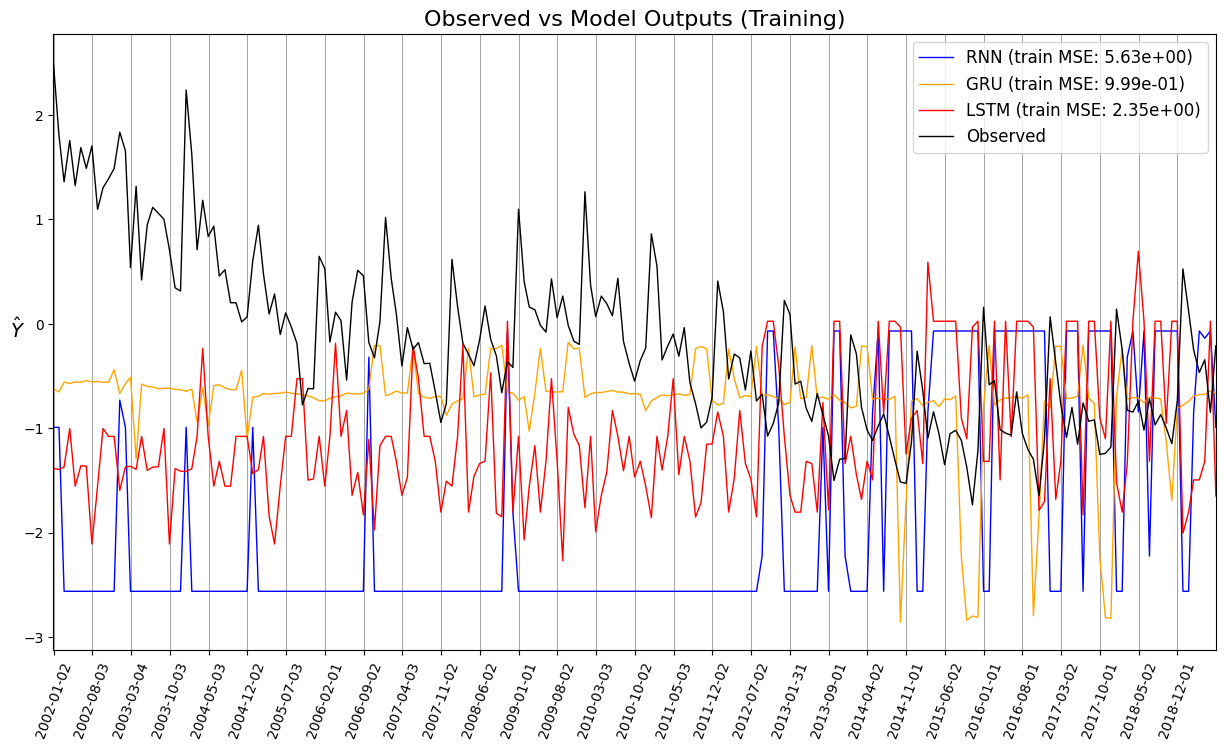

In [63]:
max_pts = 10**4
compare = params.keys() # e.g. ['rnn', 'alpharnn'] or ['lstm']
l, u = (None, None) # lower and upper indices of range to plot 
ds = max(1, len(y_train[l:u])//max_pts) # Downsampling ratio for under `max_pts`
                                        # per series.  Set `None` to disable. 

fig = plt.figure(figsize=(15,8))
x_vals = y_train_timestamps[l:u:ds]
for key in compare:
    y_vals = params4[key]['pred_train'][l:u:ds]
    label = params4[key]['label'] + ' (train MSE: %.2e)' % params4[key]['MSE_train']
    plt.plot(x_vals, y_vals, c=params2[key]['color'], label=label, lw=1)
plt.plot(x_vals, y_train[l:u:ds], c="black", label="Observed", lw=1)
start, end = x_vals.min(), x_vals.max()
xticks =  [start.date() + timedelta(days=(1+i)) for i in range(1 + (end - start).days)]
xticks = xticks[::max(1, len(xticks)//30)]
for t in xticks: plt.axvline(x=t, c='gray', linewidth=0.5, zorder=0)
plt.xticks(xticks, rotation=70)
plt.xlim(start, end)
plt.ylabel('$\hat{Y}$', rotation=0, fontsize=14)
plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model Outputs (Training)', fontsize=16);

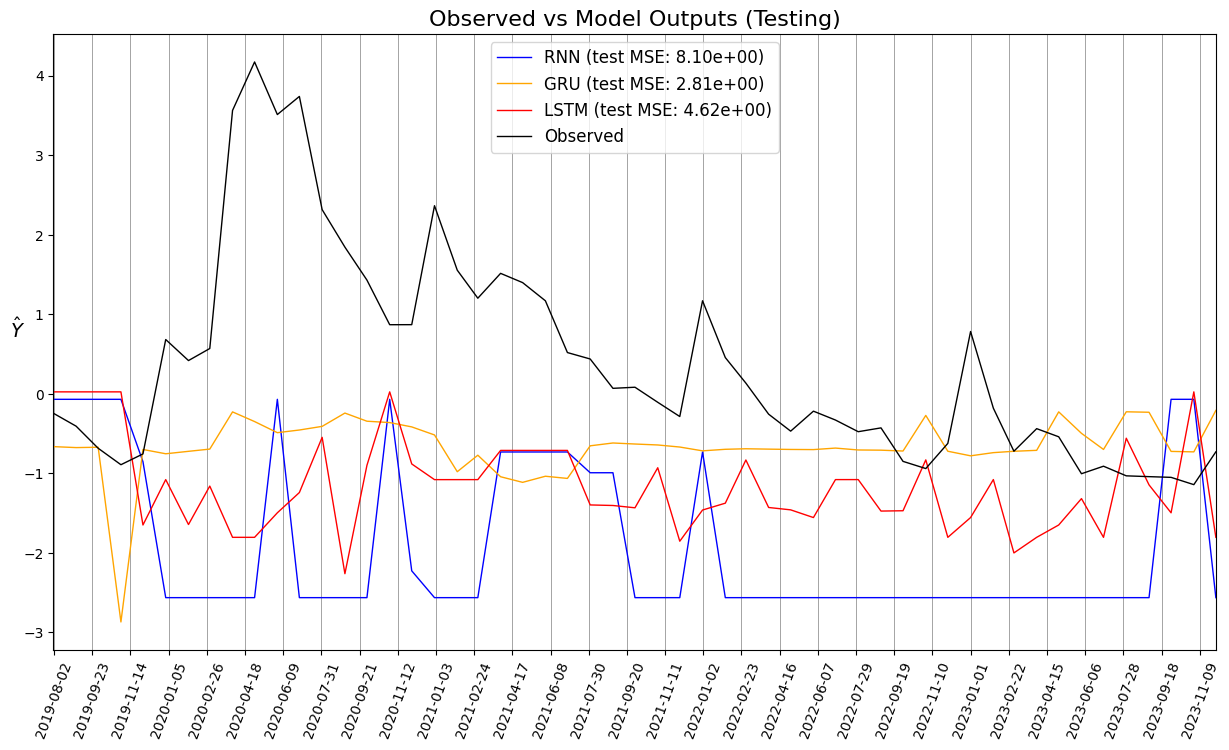

In [64]:
compare = params.keys() # e.g. ['rnn', 'alpharnn'] or ['lstm']
l, u = (None, None) # lower and upper indices of range to plot 
ds = max(1, len(y_train[l:u])//max_pts) # Downsampling ratio for under `max_pts`
                                        # per series.  Set `None` to disable.
fig = plt.figure(figsize=(15,8))
x_vals = y_test_timestamps[l:u:ds]
for key in compare:
    y_vals = params4[key]['pred_test'][l:u:ds]
    label = params4[key]['label'] + ' (test MSE: %.2e)' % params4[key]['MSE_test']
    plt.plot(x_vals, y_vals, c=params2[key]['color'], label=label, lw=1)
plt.plot(x_vals, y_test[l:u:ds], c="black", label="Observed", lw=1)
start, end = x_vals.min(), x_vals.max()
xticks =  [start.date() + timedelta(days=(1+i)) for i in range(1 + (end - start).days)]
xticks = xticks[::max(1, len(xticks)//30)]
for t in xticks: plt.axvline(x=t, c='gray', linewidth=0.5, zorder=0)
plt.xticks(xticks, rotation=70)
plt.xlim(start, end)
plt.ylabel('$\hat{Y}$', rotation=0, fontsize=14)
plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model Outputs (Testing)', fontsize=16);

# MSE de las redes

El cálculo del RMSE (raíz del error cuadrático medio) utlizando los datos reales junto a las predicciones en la escala original se obtiene simplemente multiplicando por la desviación estándar de la estandarización.

In [66]:
print('Modelo sin covariables de estacionalidad')
for key in params.keys():
    print('El MSE de la red',key, 'en el conjunto de prueba es',sigma**2*params[key]['MSE_test'])
    
print('Modelo con covariables de estacionalidad dummy')
for key in params2.keys():
    print('El MSE de la red',key, 'en el conjunto de prueba es',sigma**2*params2[key]['MSE_test'])

print('Modelo con covariables de estacionalidad Componentes de Fourier')
for key in params3.keys():
    print('El MSE de la red',key, 'en el conjunto de prueba es',sigma**2*params3[key]['MSE_test'])

print('Modelo con covariable de tendencia')
for key in params4.keys():
    print('El MSE de la red',key, 'en el conjunto de prueba es',sigma**2*params4[key]['MSE_test'])

Modelo sin covariables de estacionalidad
El MSE de la red rnn en el conjunto de prueba es 24.6913879926078
El MSE de la red gru en el conjunto de prueba es 12.436164781499672
El MSE de la red lstm en el conjunto de prueba es 20.404430802748056
Modelo con covariables de estacionalidad dummy
El MSE de la red rnn en el conjunto de prueba es 18.22340966286557
El MSE de la red gru en el conjunto de prueba es 15.15553922792918
El MSE de la red lstm en el conjunto de prueba es 30.911564827133045
Modelo con covariables de estacionalidad Componentes de Fourier
El MSE de la red rnn en el conjunto de prueba es 46.307593086687376
El MSE de la red gru en el conjunto de prueba es 46.99196656126096
El MSE de la red lstm en el conjunto de prueba es 26.411085859321894
Modelo con covariable de tendencia
El MSE de la red rnn en el conjunto de prueba es 48.2425795457436
El MSE de la red gru en el conjunto de prueba es 16.722793463595746
El MSE de la red lstm en el conjunto de prueba es 27.494889007054702


# Gráficos de predicción vs serie original
### Modelo sin covariables de tendencia y estacionalidad

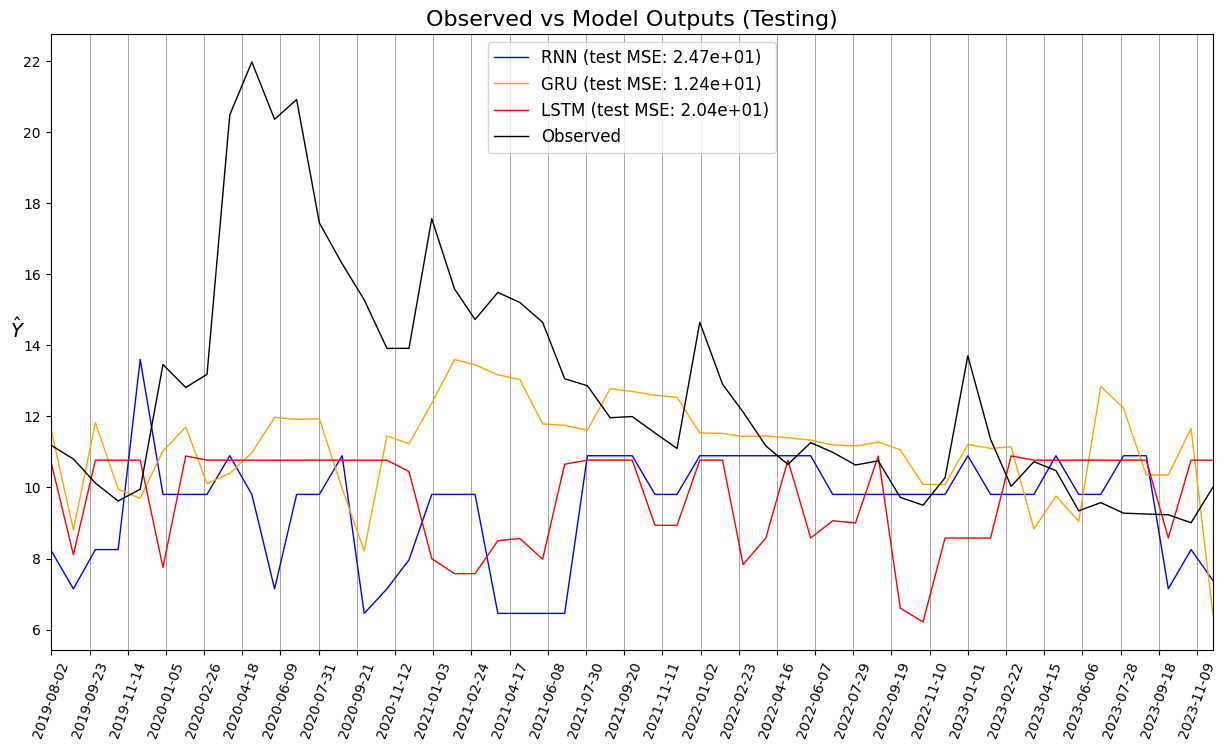

In [67]:
compare = params.keys() # e.g. ['rnn', 'alpharnn'] or ['lstm']
l, u = (None, None) # lower and upper indices of range to plot 
ds = max(1, len(y_train[l:u])//max_pts) # Downsampling ratio for under `max_pts`
                                        # per series.  Set `None` to disable.
fig = plt.figure(figsize=(15,8))
x_vals = y_test_timestamps[l:u:ds]
for key in compare:
    y_vals = sigma*params[key]['pred_test'][l:u:ds]+mu
    label = params[key]['label'] + ' (test MSE: %.2e)' % (params[key]['MSE_test']*sigma**2)
    plt.plot(x_vals, y_vals, c=params[key]['color'], label=label, lw=1)
plt.plot(x_vals, mu+sigma*y_test[l:u:ds], c="black", label="Observed", lw=1)
start, end = x_vals.min(), x_vals.max()
xticks =  [start.date() + timedelta(days=(1+i)) for i in range(1 + (end - start).days)]
xticks = xticks[::max(1, len(xticks)//30)]
for t in xticks: plt.axvline(x=t, c='gray', linewidth=0.5, zorder=0)
plt.xticks(xticks, rotation=70)
plt.xlim(start, end)
plt.ylabel('$\hat{Y}$', rotation=0, fontsize=14)
plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model Outputs (Testing)', fontsize=16);

## Modelos con covariables de estacionalidad dummy

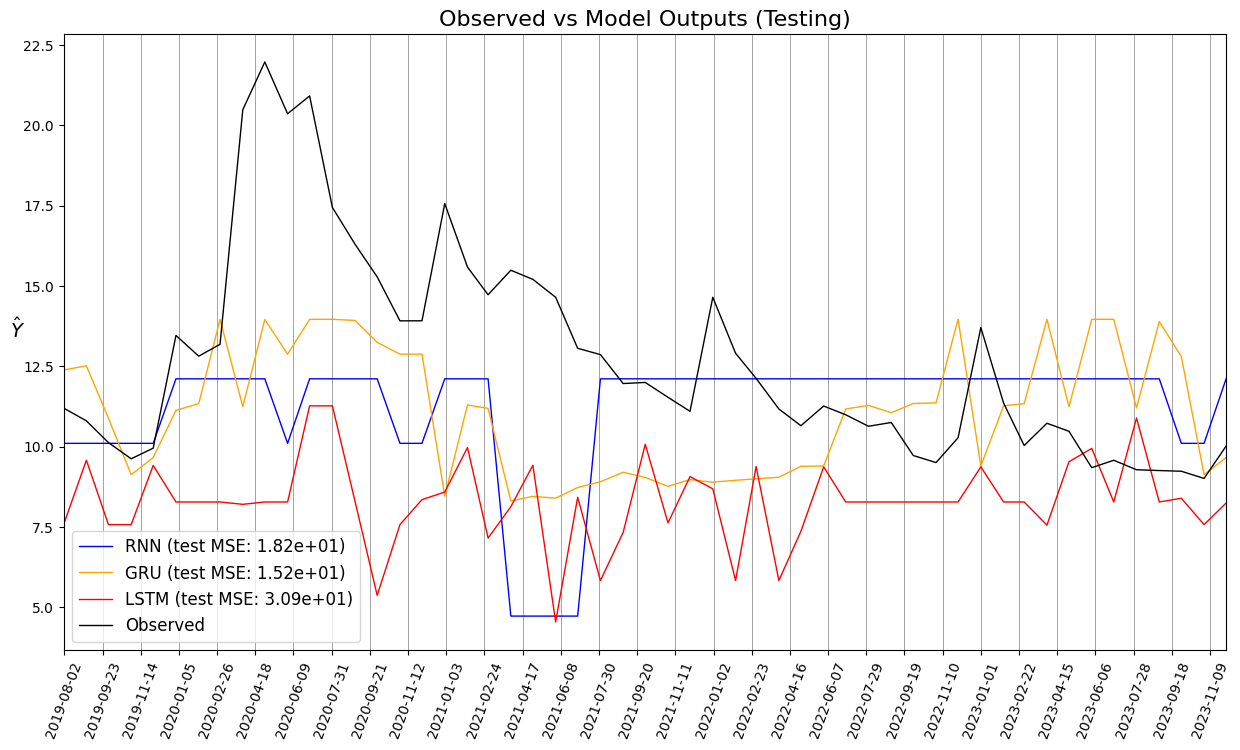

In [68]:
compare = params.keys() # e.g. ['rnn', 'alpharnn'] or ['lstm']
l, u = (None, None) # lower and upper indices of range to plot 
ds = max(1, len(y_train[l:u])//max_pts) # Downsampling ratio for under `max_pts`
                                        # per series.  Set `None` to disable.
fig = plt.figure(figsize=(15,8))
x_vals = y_test_timestamps[l:u:ds]
for key in compare:
    y_vals = sigma*params2[key]['pred_test'][l:u:ds]+mu
    label = params2[key]['label'] + ' (test MSE: %.2e)' % (params2[key]['MSE_test']*sigma**2)
    plt.plot(x_vals, y_vals, c=params2[key]['color'], label=label, lw=1)
plt.plot(x_vals, mu+sigma*y_test[l:u:ds], c="black", label="Observed", lw=1)
start, end = x_vals.min(), x_vals.max()
xticks =  [start.date() + timedelta(days=(1+i)) for i in range(1 + (end - start).days)]
xticks = xticks[::max(1, len(xticks)//30)]
for t in xticks: plt.axvline(x=t, c='gray', linewidth=0.5, zorder=0)
plt.xticks(xticks, rotation=70)
plt.xlim(start, end)
plt.ylabel('$\hat{Y}$', rotation=0, fontsize=14)
plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model Outputs (Testing)', fontsize=16);

## Modelo con covariables de estacionalidad componentes de Fourier

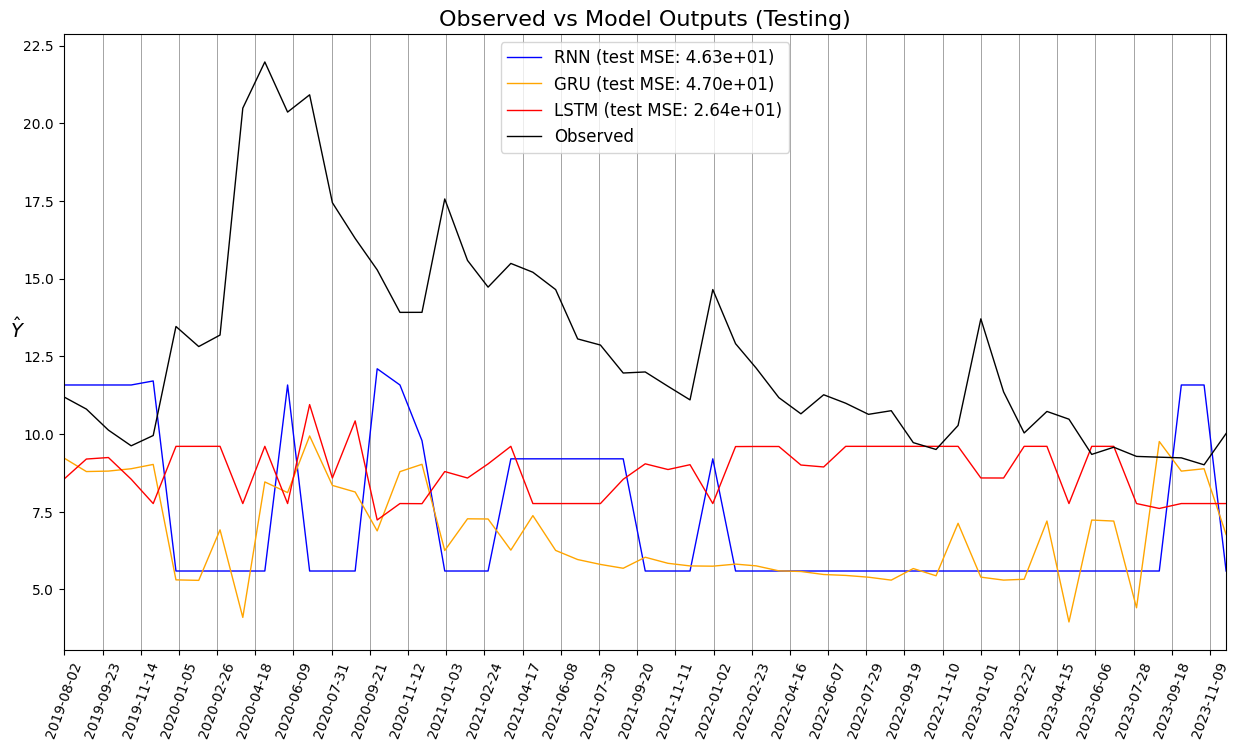

In [69]:
compare = params.keys() # e.g. ['rnn', 'alpharnn'] or ['lstm']
l, u = (None, None) # lower and upper indices of range to plot 
ds = max(1, len(y_train[l:u])//max_pts) # Downsampling ratio for under `max_pts`
                                        # per series.  Set `None` to disable.
fig = plt.figure(figsize=(15,8))
x_vals = y_test_timestamps[l:u:ds]
for key in compare:
    y_vals = sigma*params3[key]['pred_test'][l:u:ds]+mu
    label = params3[key]['label'] + ' (test MSE: %.2e)' % (params3[key]['MSE_test']*sigma**2)
    plt.plot(x_vals, y_vals, c=params3[key]['color'], label=label, lw=1)
plt.plot(x_vals, mu+sigma*y_test[l:u:ds], c="black", label="Observed", lw=1)
start, end = x_vals.min(), x_vals.max()
xticks =  [start.date() + timedelta(days=(1+i)) for i in range(1 + (end - start).days)]
xticks = xticks[::max(1, len(xticks)//30)]
for t in xticks: plt.axvline(x=t, c='gray', linewidth=0.5, zorder=0)
plt.xticks(xticks, rotation=70)
plt.xlim(start, end)
plt.ylabel('$\hat{Y}$', rotation=0, fontsize=14)
plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model Outputs (Testing)', fontsize=16);

## Modelo con componente de tendencia

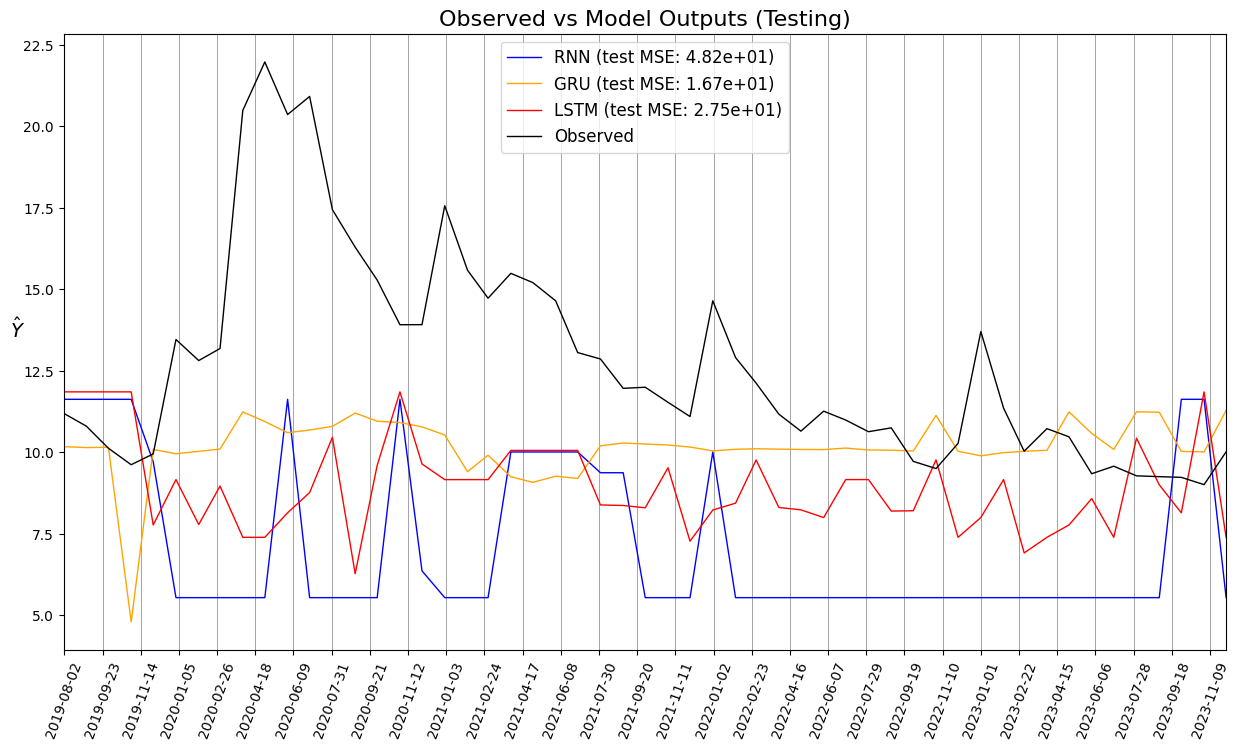

In [70]:
compare = params.keys() # e.g. ['rnn', 'alpharnn'] or ['lstm']
l, u = (None, None) # lower and upper indices of range to plot 
ds = max(1, len(y_train[l:u])//max_pts) # Downsampling ratio for under `max_pts`
                                        # per series.  Set `None` to disable.
fig = plt.figure(figsize=(15,8))
x_vals = y_test_timestamps[l:u:ds]
for key in compare:
    y_vals = sigma*params4[key]['pred_test'][l:u:ds]+mu
    label = params4[key]['label'] + ' (test MSE: %.2e)' % (params4[key]['MSE_test']*sigma**2)
    plt.plot(x_vals, y_vals, c=params4[key]['color'], label=label, lw=1)
plt.plot(x_vals, mu+sigma*y_test[l:u:ds], c="black", label="Observed", lw=1)
start, end = x_vals.min(), x_vals.max()
xticks =  [start.date() + timedelta(days=(1+i)) for i in range(1 + (end - start).days)]
xticks = xticks[::max(1, len(xticks)//30)]
for t in xticks: plt.axvline(x=t, c='gray', linewidth=0.5, zorder=0)
plt.xticks(xticks, rotation=70)
plt.xlim(start, end)
plt.ylabel('$\hat{Y}$', rotation=0, fontsize=14)
plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model Outputs (Testing)', fontsize=16);